In [1]:
import os
import cv2
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms as pth_transforms
import numpy as np

from PIL import Image
from segment_anything import sam_model_registry 
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import SamPredictor
from torch.utils.data import Dataset, DataLoader
import glob

In [2]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  

# Example Image

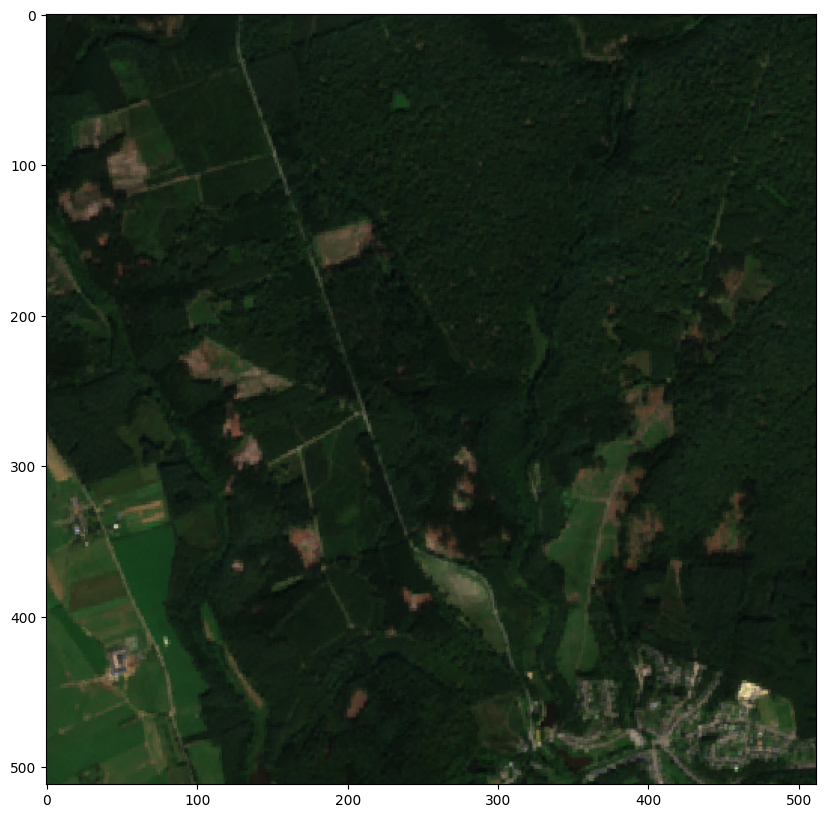

In [5]:
import tifffile 

N = 111
image_path = f'/media/daniel/data1/sentinel2/2021_seasons/Belgium_summer2021/images/Belgium_image_tile_{N:04}.tif'

img = tifffile.imread(image_path)
img = img.transpose(1, 2, 0)
img = img[:, :, [3, 2, 1]] 
img = img / np.max(img)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.axis('on')
plt.show()


# SAM model

In [6]:
sam_H_checkpoint = '/home/daniel/Documents/work/SAM/models/sam_vit_h_4b8939.pth'
sam_L_checkpoint = '/home/daniel/Documents/work/SAM/models/sam_vit_l_0b3195.pth'

type_H = 'vit_h'
type_L = 'vit_l'

from segment_anything import sam_model_registry, SamPredictor

sam = sam_model_registry[type_H](sam_H_checkpoint)
sam.to('cuda')

predictor = SamPredictor(sam)

In [7]:
img = (img * 255).astype(np.uint8)
predictor.set_image(img)

In [8]:
input_point = np.array([[255,255], [350,350]])
input_label = np.array([1, 0])

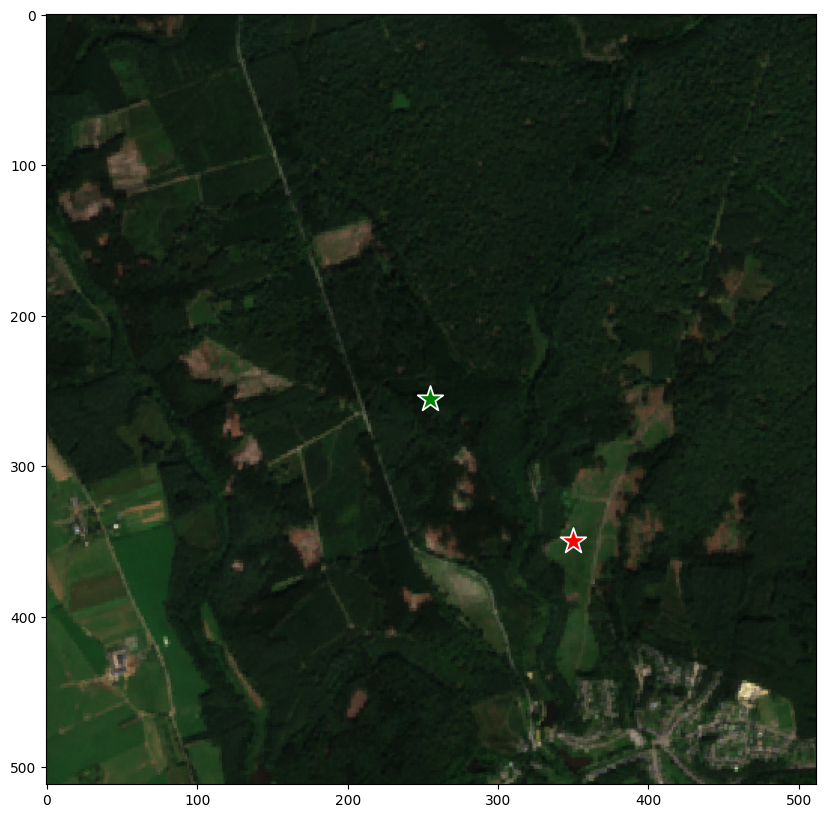

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [10]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [11]:
masks.shape

(3, 512, 512)

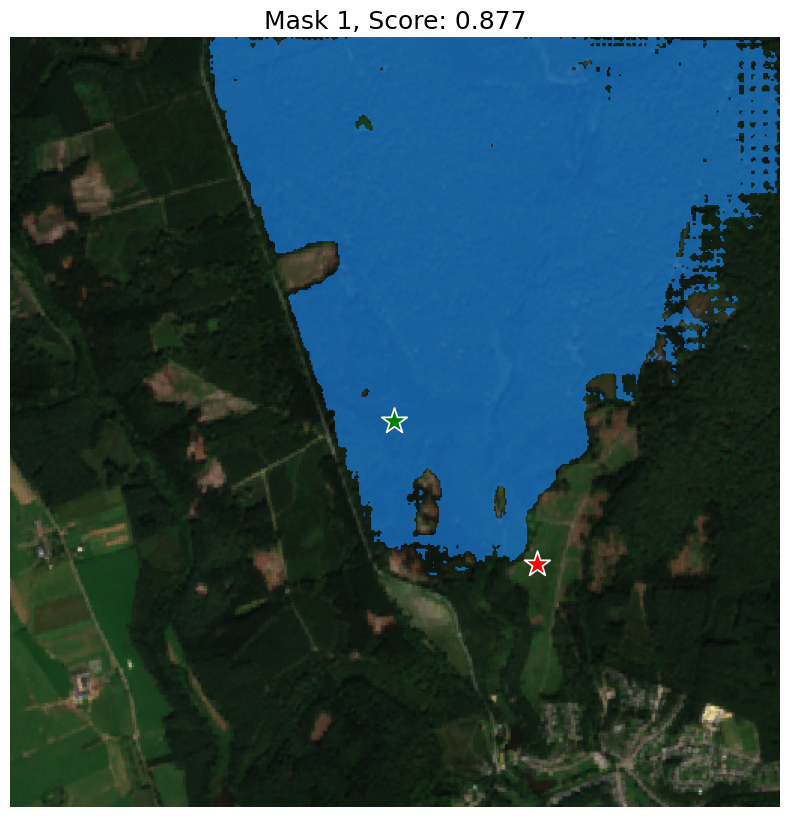

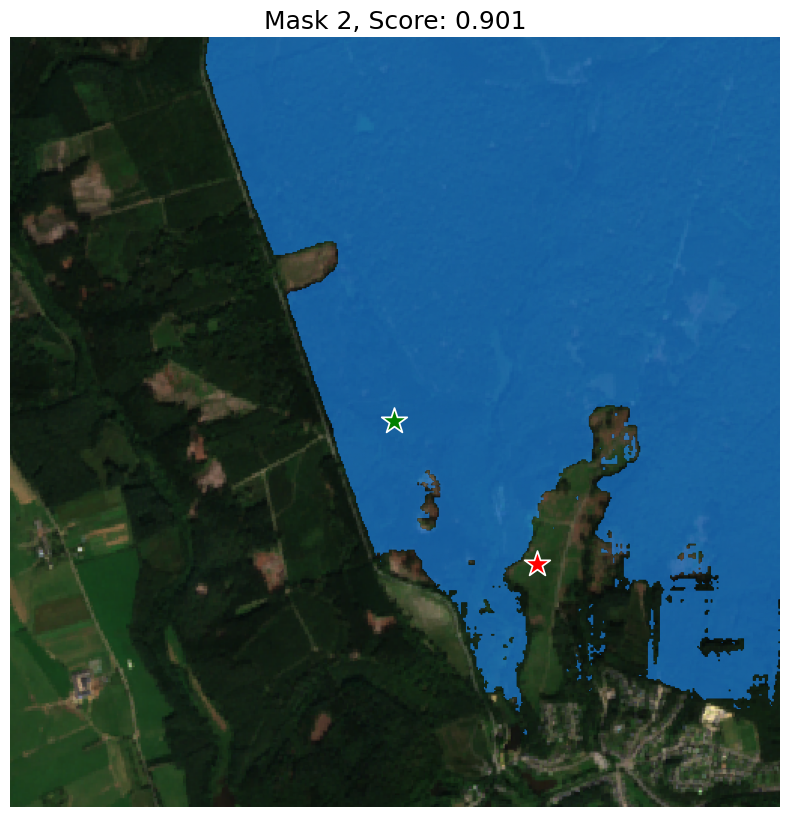

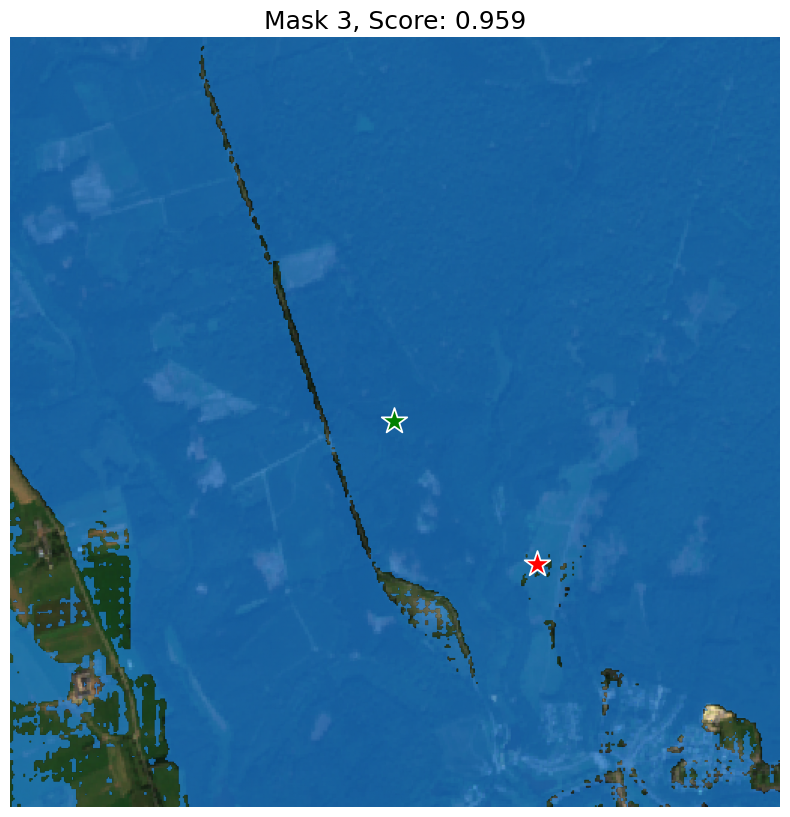

In [12]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [13]:
input_box = np.array([200,200,400,400])

In [14]:
masks, _, _ = predictor.predict(
    point_coords=None,
    point_labels=None,
    box=input_box[None, :],
    multimask_output=False,
)

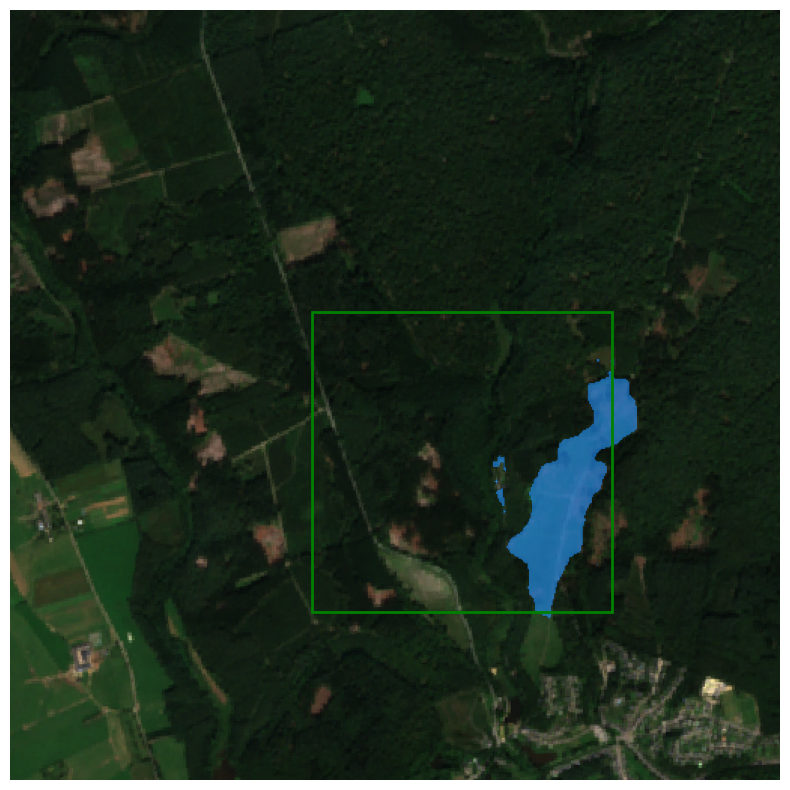

In [15]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.axis('off')
plt.show()

In [16]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    box=input_box,
    multimask_output=False,
)

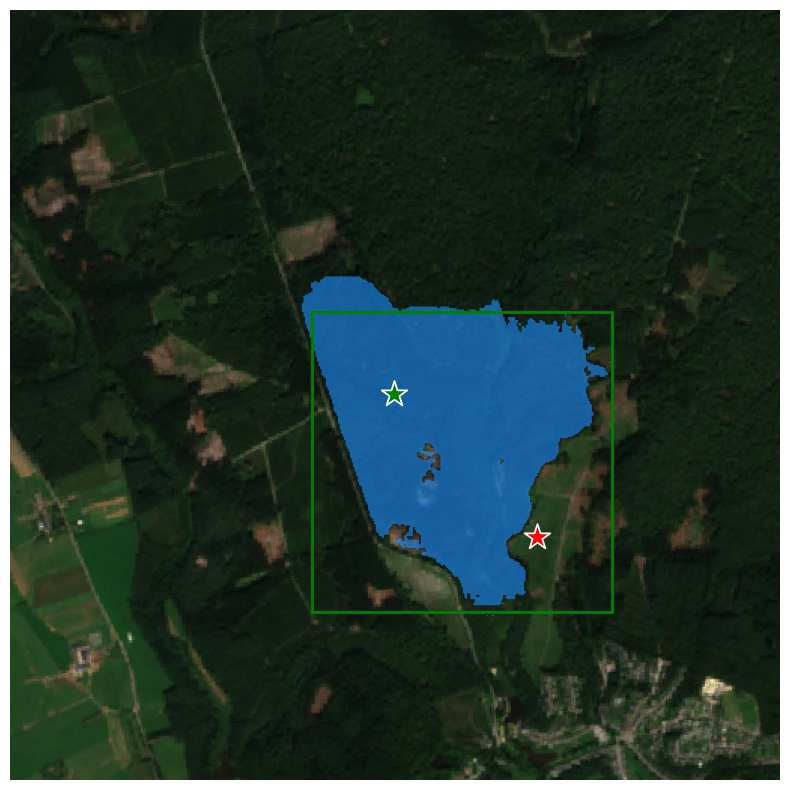

In [17]:
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()

In [18]:
mask_generator1 = SamAutomaticMaskGenerator(sam, points_per_batch=16)

In [19]:
masks = mask_generator1.generate(img)
masks_orig = masks.copy()

In [20]:
def show_anns(anns, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m**0.5)))

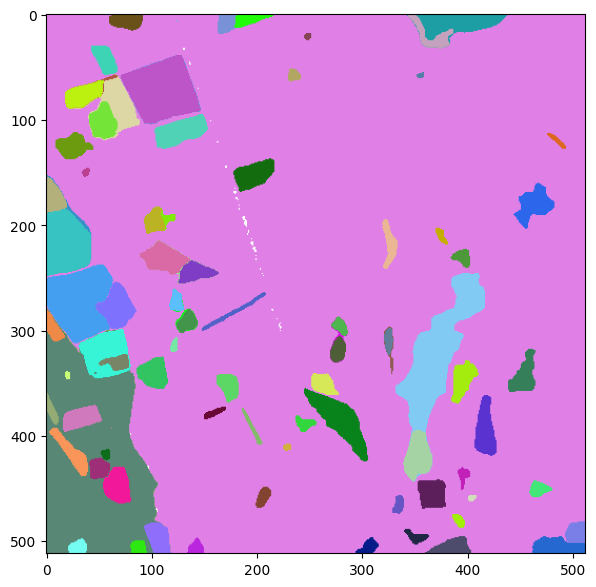

In [21]:
plt.figure(figsize=(7,7))
# plt.imshow(img)
# show_points(input_point, input_label, plt.gca())
show_anns(masks, plt.gca())
plt.axis('on')
plt.show()  

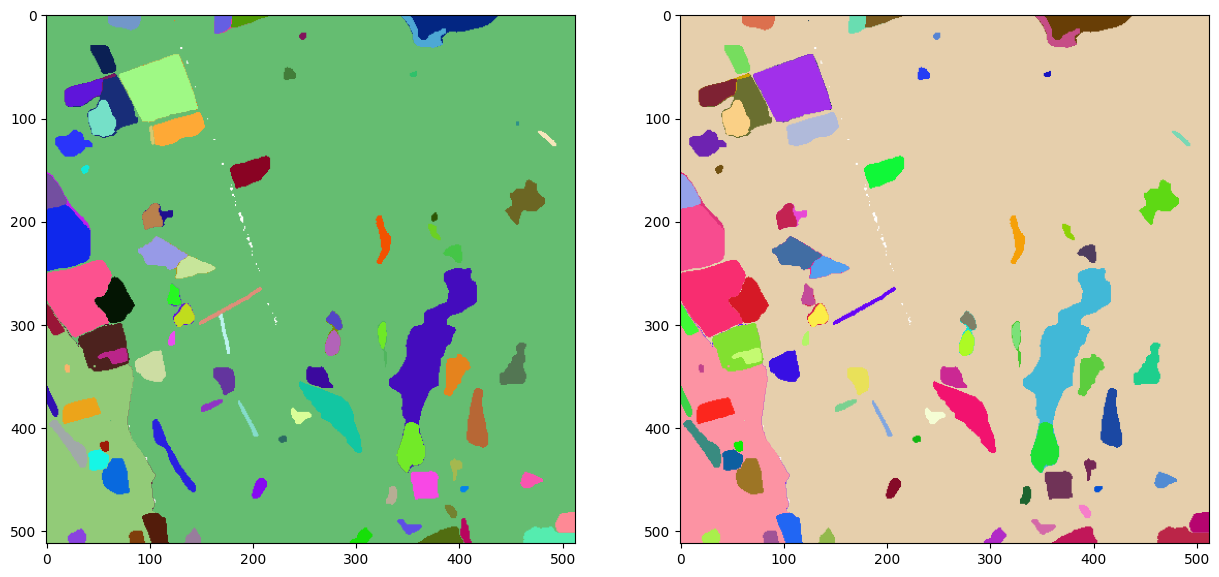

In [24]:
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side = 32,
    pred_iou_thresh = 0.80,
    stability_score_thresh= 0.95,
    stability_score_offset= 1,
    box_nms_thresh= 0.7,
    crop_n_layers= 0,
    crop_nms_thresh=0.7,
    crop_overlap_ratio=512/1500,
    crop_n_points_downscale_factor= 1,
    point_grids= None,
    min_mask_region_area= 0
)

masks = mask_generator.generate(img)

# plot two masks side by side
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
show_anns(masks, axs[0])
show_anns(masks_orig, axs[1])


In [25]:
len(masks)

93

# ESA world cover mask

In [43]:
def show_anns_masked(anns, MASK, axes=None):
    if len(anns) == 0:
        return
    if axes:
        ax = axes
    else:
        ax = plt.gca()
        ax.set_autoscale_on(False)
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
            img = img * MASK
        ax.imshow(np.dstack((img, m**0.5)))

def load_image_mask(idx):
    PATH = '/media/daniel/data1/sentinel2/2021_seasons/Belgium_summer2021'
    image_path = f'{PATH}/images/Belgium_image_tile_{idx:04}.tif'
    mask_path = f'{PATH}/masks/Belgium_mask_tile_{idx:04}.tif'

    img = tifffile.imread(image_path)
    img = img.transpose(1, 2, 0)
    img = img[:, :, [3, 2, 1]]
    img = img / np.max(img)
    img = (img * 255).astype(np.uint8)

    mask = tifffile.imread(mask_path)
    mask_image = np.zeros((mask.shape)+(3,))
    mask_image[mask == 10] = np.array([0, 255, 0])

    img_T = img.copy()
    img_T[mask != 10] = np.array([0, 0, 0])

    img_F = img.copy()
    img_F[mask == 10] = np.array([0, 0, 0])
    
    return img, mask
    
    

In [45]:
PATH = '/media/daniel/data1/sentinel2/2021_seasons/Belgium_summer2021'
idx = 111
image_path = f'{PATH}/images/Belgium_image_tile_{idx:04}.tif'
mask_path = f'{PATH}/masks/Belgium_mask_tile_{idx:04}.tif'

img = tifffile.imread(image_path)
img = img.transpose(1, 2, 0)
img = img[:, :, [3, 2, 1]]
img = img / np.max(img)
img = (img * 255).astype(np.uint8)

mask = tifffile.imread(mask_path)
mask_image = np.zeros((mask.shape)+(3,))
mask_image[mask == 10] = np.array([0, 255, 0])

img_T = img.copy()
img_T[mask != 10] = np.array([0, 0, 0])

img_F = img.copy()
img_F[mask == 10] = np.array([0, 0, 0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


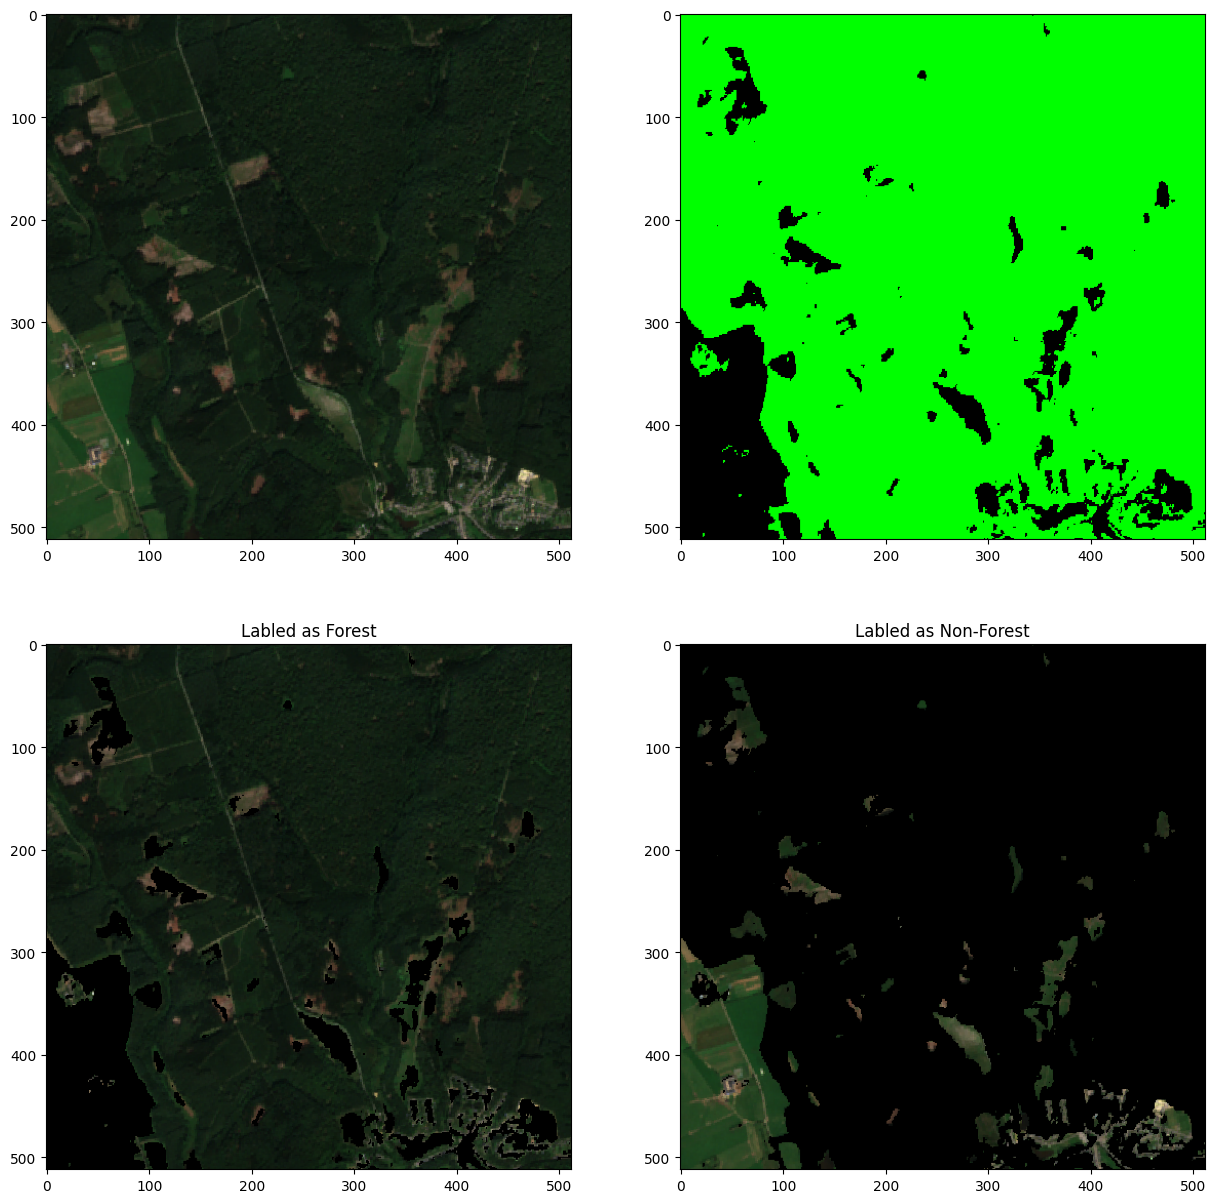

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0,0].imshow(img)
axs[0,1].imshow(mask_image)
axs[1,0].set_title('Labled as Forest')
axs[1,0].imshow(img_T)
axs[1,1].set_title('Labled as Non-Forest')
axs[1,1].imshow(img_F)

93


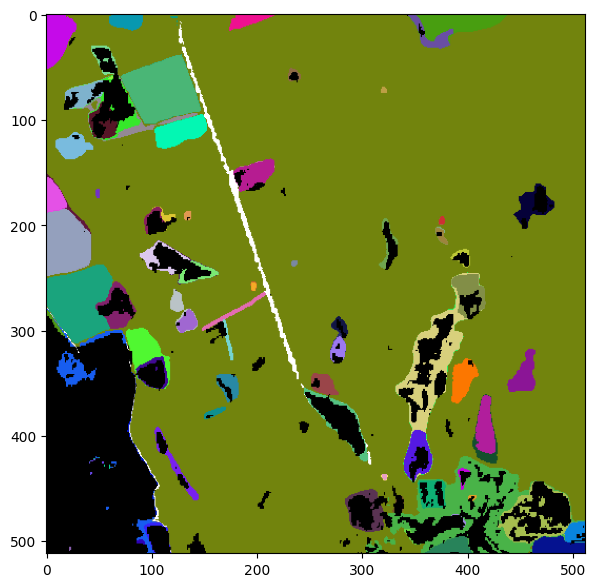

In [180]:
mask_generator = SamAutomaticMaskGenerator(
    sam,
    points_per_side = 25,
    pred_iou_thresh = 0.88,
    stability_score_thresh= 0.85,
    stability_score_offset= 1,
    box_nms_thresh= 0.7,
    crop_n_layers= 0,
    crop_nms_thresh=0.7,
    crop_overlap_ratio=512/1500,
    crop_n_points_downscale_factor= 1,
    point_grids= None,
    min_mask_region_area= 0
)

masks = mask_generator.generate(img)
MASK = np.ones(img.shape)
MASK[mask != 10] = np.array([0, 0, 0])
fig, axs = plt.subplots(1, 1, figsize=(7, 7))
sorted_masks = sorted(masks, reverse=True, key=lambda x: x['segmentation'].sum())
show_anns_masked(sorted_masks,  MASK,axs)
print(len(masks))
# img_2[mask != 10]
# show_anns(masks_orig, axs[1])

In [135]:
sorted_masks = sorted(masks, reverse=True, key=lambda x: x['segmentation'].sum())
[sorted_masks[i]['segmentation'].sum() for i in range(len(sorted_masks))]
scores = [(x['segmentation']*(mask==10)).sum() / x['segmentation'].sum() for x in sorted_masks]

Score: 0.628, Area: 653, Tree are: 410


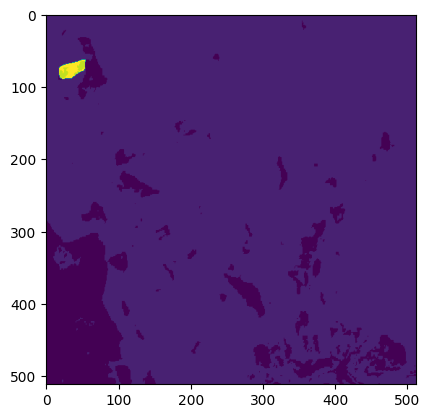

In [174]:
N = 50
print(f'Score: {scores[N]:.3f}, Area: {sorted_masks[N]["segmentation"].sum():.0f}, Tree are: {(sorted_masks[N]["segmentation"] * (mask==10)).sum():.0f}')
plt.imshow(sorted_masks[N]['segmentation'] + (mask == 10)*0.1)

In [127]:
r = np.zeros((mask.shape))
for m in masks:
    r += m['segmentation']

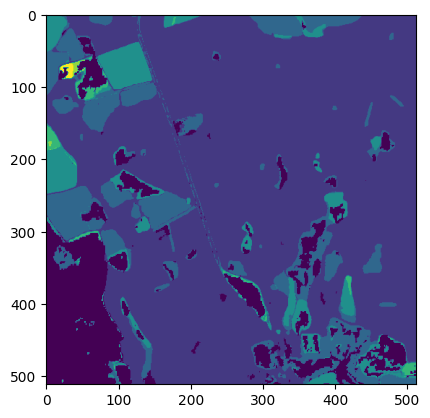

In [129]:
plt.imshow(r * (mask == 10))

# 1. Policy - remove areas with high percentage of non-tree pixels from original mask